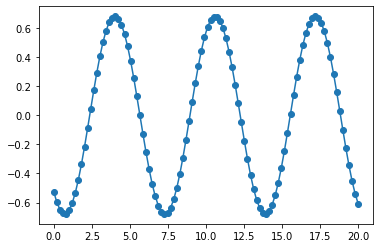

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

omega_s, omega_l = 0.5, 2
A_s, A_l = 0.5, 1.0
phi_s, phi_l = 0, 2 * np.pi


num_trajectories = 100
num_points_per_trajectory = 100

ts = np.linspace(0, 20, num_points_per_trajectory)

# draw omega from U[omega_s, omega_l]
omegas = np.random.uniform(omega_s, omega_l, size=num_trajectories)
As = np.random.uniform(A_s, A_l, size=num_trajectories)
phis = np.random.uniform(phi_s, phi_l, size=num_trajectories)

xs = As[:,None] * np.sin(omegas[:,None] * ts[None,:] + phis[:,None])

plt.plot(ts, xs[3], marker='o')



In [15]:
vocab_size = 100

# map x to vocab_size bins
h = 2 / vocab_size
xs_binned = np.floor((xs + 1) / h).astype(int)
coordinates = np.linspace(-1, 1, vocab_size)
inputs_id = torch.from_numpy(xs_binned).long()


In [16]:
from model import GPTConfig, GPT

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

GPTConfig.block_size = num_points_per_trajectory
GPTConfig.vocab_size = vocab_size
GPTConfig.n_layer = 2
GPTConfig.n_head = 1
GPTConfig.n_embd = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT(GPTConfig).to(device)
inputs_id = inputs_id.to(device)

logits, loss = model.forward(inputs_id[:,:-1], inputs_id[:,1:])
loss


number of parameters: 0.028672M


tensor(4.5985, device='cuda:0', grad_fn=<NllLossBackward0>)

In [17]:
weight_decay = 0.000
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=weight_decay)

n_steps = 201

losses = []
for i in range(n_steps):
    logits, loss = model.forward(inputs_id[:,:-1], inputs_id[:,1:])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item()}")



Step 0, Loss: 4.598457336425781
Step 100, Loss: 3.052039623260498
Step 200, Loss: 2.4203271865844727


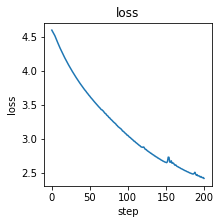

In [18]:
plt.figure(figsize=(3, 3))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')

plt.title('loss')
plt.show()

Linear fit score: 0.9952988889345263


Text(0, 0.5, 'learned')

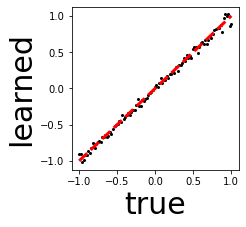

In [19]:
# linear regression from wte to xs
from sklearn.linear_model import LinearRegression
xs = np.linspace(-1, 1, vocab_size)
wte = model.transformer.wte.weight.cpu().detach().numpy()

solver = LinearRegression()
solver.fit(wte, xs)

xs_pred = solver.predict(wte)

plt.figure(figsize=(3, 3))
plt.plot(xs, xs_pred, color='black', marker='o', lw=0, markersize=2)
plt.plot([-1, 1], [-1, 1], color='red', lw=3, linestyle='--')
score = solver.score(wte, xs)
print(f"Linear fit score: {score}")
plt.xlabel('true', fontsize=30)
plt.ylabel('learned', fontsize=30)
#plt.savefig(f'./plots/sine_map_linear_fit_vocab_{vocab_size}.png', dpi=300, bbox_inches='tight')




In [20]:
from model import GPTConfig, GPT

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

GPTConfig.block_size = num_points_per_trajectory
GPTConfig.vocab_size = vocab_size
GPTConfig.n_layer = 2
GPTConfig.n_head = 1
GPTConfig.n_embd = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT(GPTConfig).to(device)
inputs_id = inputs_id.to(device)

logits, loss = model.forward(inputs_id[:,:-1], inputs_id[:,1:])
loss


number of parameters: 0.028672M


tensor(4.5985, device='cuda:0', grad_fn=<NllLossBackward0>)

In [21]:
weight_decay = 0.000
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=weight_decay)

n_steps = 201

losses = []
map_evolve = []
for i in range(n_steps):
    logits, loss = model.forward(inputs_id[:,:-1], inputs_id[:,1:])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    map_evolve.append(solver.predict(model.transformer.wte.weight.cpu().detach().numpy()))
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item()}")

Step 0, Loss: 4.598457336425781
Step 100, Loss: 3.052039623260498
Step 200, Loss: 2.4203271865844727


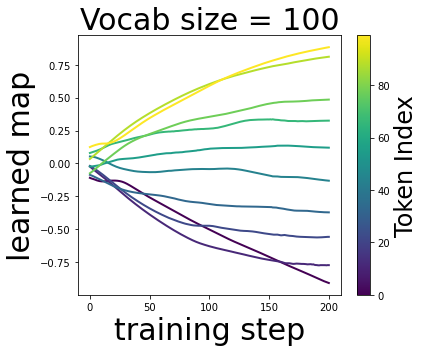

In [22]:
map_evolve = np.array(map_evolve)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Plot lines with colors
for i in range(10):
    token_idx = int(vocab_size//9*i)
    ax.plot(map_evolve[:,token_idx], color=plt.cm.viridis(i/9), label=f'Token {token_idx}', linewidth=2)

# Create colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Create a mappable for the colorbar
token_indices = np.array([vocab_size//9*i for i in range(10)])
norm = Normalize(vmin=token_indices.min(), vmax=token_indices.max())
sm = ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Token Index', fontsize=24)

ax.set_xlabel('training step', fontsize=30)
ax.set_ylabel('learned map', fontsize=30)
plt.title(f'Vocab size = {vocab_size}', fontsize=30)
plt.tight_layout()

#plt.savefig(f'./plots/sine_map_evolve_vocab_{vocab_size}.png', dpi=300, bbox_inches='tight')



